# SCAN: Initial modeling with memory models

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import layers

import tensorflow_datasets as tfds
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import data_utils
import model_utils

from tqdm import tqdm, trange

import sys; sys.path.append('../')
import transformer_modules
import utils

[TODO]

- implement gating
- 2-stage training

## Date prep

In [2]:
scan_split = 'length'
eval_ds_size = 1000

In [3]:
train_ds, test_ds, command_vectorizer, action_vectorizer = data_utils.load_scan_ds(scan_split)

tokenized_target_train tf.Tensor(
[[8 2 2 ... 0 0 0]
 [8 6 6 ... 0 0 0]
 [8 5 3 ... 0 0 0]
 ...
 [8 3 7 ... 0 0 0]
 [8 2 2 ... 0 0 0]
 [8 3 3 ... 0 0 0]], shape=(16990, 49), dtype=int64)
tokenized_target_test tf.Tensor(
[[8 2 2 ... 0 0 0]
 [8 6 6 ... 0 0 0]
 [8 5 3 ... 0 0 0]
 ...
 [8 3 7 ... 0 0 0]
 [8 2 2 ... 0 0 0]
 [8 3 3 ... 0 0 0]], shape=(16990, 49), dtype=int64)


In [4]:
print('# training samples:', len(train_ds))
print('# testing samples:', len(test_ds))
print()

print('sample of input/target/label samples...')
# print sample of dataset
for (s, t), y in train_ds.take(3):
    print(f'INPUT: {data_utils.invert_seq_vector(s.numpy(), command_vectorizer)}')
    print(f'INPUT: {s.numpy()}')
    print(f'TARGET: {data_utils.invert_seq_vector(t.numpy(), action_vectorizer)}')
    print(f'TARGET: {t.numpy()}')
    print(f'LABEL: {data_utils.invert_seq_vector(y.numpy(), action_vectorizer)}')
    print(f'LABEL: {y.numpy()}')
    print()

# training samples: 16990
# testing samples: 3920

sample of input/target/label samples...
INPUT: turn around right thrice after walk opposite right thrice
INPUT: [14  9  2  6  8 10  5  2  6]
TARGET: <START> I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <END>                          
TARGET: [8 2 2 4 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
LABEL: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <END>                           
LABEL: [2 2 4 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 

In [5]:
mem_train_ds = data_utils.create_memory_ds(train_ds, n_mems=16)
mem_test_ds = data_utils.create_memory_ds(test_ds, n_mems=16, memory_bank=train_ds)

In [9]:
# TODO: perhaps sample via a generator so that different random samples of memory can be used for each epoch/batch?
# this is at the expense of speed. from_tensor_slices is faster since .from_generator runs in python rather than C++

## Utilities

In [6]:
def create_memory_processor(embedding_dim, enc_kwargs, dec_kwargs, hidden_dense_size,
    source_vocab=len(command_vectorizer.get_vocabulary()), target_vocab=len(action_vectorizer.get_vocabulary())):

    # define layers
    x_embedder = layers.Embedding(input_dim=source_vocab, output_dim=embedding_dim)
    y_embedder = layers.Embedding(input_dim=target_vocab, output_dim=embedding_dim)
    add_pos_embedding_src = transformer_modules.AddPositionalEmbedding()
    add_pos_embedding_tgt = transformer_modules.AddPositionalEmbedding()

    # NOTE: currently, self-attention in the decoder of the memory processor is causal! need not be
    encoder = transformer_modules.Encoder(**enc_kwargs)
    decoder = transformer_modules.Decoder(**dec_kwargs)

    hidden_dense = layers.Dense(hidden_dense_size, activation='relu')
    out_dense = layers.Dense(action_vectorizer.vocabulary_size())

    # define model
    inputs = layers.Input(shape=train_ds.element_spec[0][0].shape)
    targets = layers.Input(shape=train_ds.element_spec[0][1].shape)
    x = x_embedder(inputs)
    x = add_pos_embedding_src(x)
    x = encoder(x)
    y = y_embedder(targets)
    y = add_pos_embedding_tgt(y)
    y = decoder(y, x)
    out = y

    model = tf.keras.Model(inputs=[inputs, targets], outputs=out, name='memory_processor')
    return model

## End-to-end Training of Memory Model

In [7]:
# hyperparams
source_vocab = len(command_vectorizer.get_vocabulary())
target_vocab = len(action_vectorizer.get_vocabulary())
embedding_dim = 64

hidden_dense_size = 128
enc_kwargs = dict(num_layers=2, num_heads=4, dff=128, layernorm_first=True)
hier_attn_kwargs = dict(key_dim=64//4, value_dim=None, n_heads=4, symmetric_kernel=False)
dec_kwargs = dict(num_layers=2, num_heads=4, dff=128, layernorm_first=True, hier_attn_kwargs=hier_attn_kwargs)

# memory-processer is a mini-transformer transformer
mem_enc_kwargs = mem_dec_kwargs = dict(num_layers=1, num_heads=4, dff=64, layernorm_first=True)
mem_processor_kwargs = dict(embedding_dim=embedding_dim, mem_enc_kwargs=mem_enc_kwargs,
    mem_dec_kwargs=mem_dec_kwargs, hidden_dense_size=64)

In [8]:
from hierarchical_memory_decoder import HierMemoryDecoder

In [19]:
class HierarchicalAttnMemoryModel(tf.keras.Model):
    def __init__(self, source_vocab, target_vocab, embedding_dim, enc_kwargs, dec_kwargs, mem_processor_kwargs, **kwargs):
        super(HierarchicalAttnMemoryModel, self).__init__(**kwargs)
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab
        self.embedding_dim = embedding_dim
        self.enc_kwargs = enc_kwargs
        self.dec_kwargs = dec_kwargs
        self.mem_processor_kwargs = mem_processor_kwargs

        self.x_embedder = layers.Embedding(input_dim=source_vocab, output_dim=embedding_dim, name='source_embedder')
        self.y_embedder = layers.Embedding(input_dim=target_vocab, output_dim=embedding_dim, name='target_embedder')
        self.add_pos_embedding_src = transformer_modules.AddPositionalEmbedding(name='pos_embedding_src')
        self.add_pos_embedding_tgt = transformer_modules.AddPositionalEmbedding(name='pos_embedding_tgt')

        self.encoder = transformer_modules.Encoder(**enc_kwargs, name='encoder')
        self.decoder = HierMemoryDecoder(**dec_kwargs, name='decoder')

        self.memory_processor = create_memory_processor(embedding_dim, mem_enc_kwargs, mem_dec_kwargs, hidden_dense_size)

        self.hidden_dense = layers.Dense(hidden_dense_size, activation='relu', name='hidden_dense')
        self.out_dense = layers.Dense(action_vectorizer.vocabulary_size(), name='output')

    def set_memory_signature(self, n_memories, mem_length):
        self.n_memories = n_memories
        self.mem_length = mem_length

    def process_memory(self, mem_inputs, mem_targets):
        # TODO: can i make the process of defining the output signature more elegant?
        # n_m = tf.shape(mem_inputs)[1]
        # tgt_len = tf.shape(mem_targets)[2]
        out_dim = self.embedding_dim #self.memory_processor.output_shape[-1]
        out_sig = tf.TensorSpec([self.n_memories, self.mem_length, out_dim], tf.float32)

        processed_mem = tf.map_fn(self.memory_processor, (mem_inputs, mem_targets), fn_output_signature=out_sig)

        # NOTE (temporary note)
        # alternatively, cross-attend from target seq to input seq? (in this case target seq is shorter)
        # but pre-training such a transformer would be difficult
        # processed_mem = tf.map_fn(self.memory_processor, (mem_targets, mem_inputs), fn_output_signature=out_sig)

        return processed_mem

    def call(self, inputs):
        ((input_seq, target_seq), (mem_inputs, mem_targets)) = inputs

        x = self.x_embedder(input_seq)
        x = self.add_pos_embedding_src(x)
        x = self.encoder(x)

        # process memory sequence
        processed_memory = self.process_memory(mem_inputs, mem_targets)

        # process target sequence (causally)
        y = self.y_embedder(target_seq)
        y = self.add_pos_embedding_tgt(y)
        y = self.decoder(y, x, processed_memory)
        out = self.hidden_dense(y)
        out = self.out_dense(out)

        return out

In [20]:
model = HierarchicalAttnMemoryModel(source_vocab, target_vocab, embedding_dim, enc_kwargs, dec_kwargs, mem_processor_kwargs)

In [21]:
# TODO: is it possible to fix building so that shapes work?
for x, y in mem_train_ds.batch(32).take(1):
    ((input_seq, target_seq), (mem_inputs, mem_targets)) = x
    print('input_seq:', input_seq.shape[1:])
    print('target_seq:', target_seq.shape[1:])
    print('mem_inputs:', mem_inputs.shape[1:])
    print('mem_targets:', mem_targets.shape[1:])
    # get shapes for building model shape

    input_shape = [None, *input_seq.get_shape().as_list()[1:]]
    target_shape = [None, *target_seq.get_shape().as_list()[1:]]
    mem_input_shape = [None, *mem_inputs.get_shape().as_list()[1:]]
    mem_target_shape = [None, *mem_targets.get_shape().as_list()[1:]]
    inputs_shape = [input_shape, target_shape, mem_input_shape, mem_target_shape]
    print(f'inputs_shape: {inputs_shape}')
    # model((input_seq, target_seq, mem_inputs, mem_targets))
    model.set_memory_signature(n_memories=mem_targets.shape[1], mem_length=mem_targets.shape[2])
    model(x)
    # model.build(inputs_shape)

model.summary()

input_seq: (9,)
target_seq: (49,)
mem_inputs: (16, 9)
mem_targets: (16, 49)
inputs_shape: [[None, 9], [None, 49], [None, 16, 9], [None, 16, 49]]
Model: "hierarchical_attn_memory_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (Embedding  multiple                  960       
 )                                                               
                                                                 
 target_embedder (Embedding  multiple                  640       
 )                                                               
                                                                 
 pos_embedding_src (AddPosi  multiple                  0         
 tionalEmbedding)                                                
                                                                 
 pos_embedding_tgt (AddPosi  multiple                  0         
 tionalEmbedding)    

In [22]:
# compile model and optimization hyperparams
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
metrics = [transformer_modules.TeacherForcingAccuracy(ignore_class=action_vectorizer.get_vocabulary().index(''))]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics, run_eagerly=False)
batch_size = 128

In [23]:
val_size = 1000
val_ds = mem_train_ds.take(val_size).batch(batch_size)
train_ds_ = mem_train_ds.skip(val_size).batch(batch_size)

In [24]:
n_epochs = 10
history = model.fit(train_ds_, validation_data=val_ds, epochs=n_epochs, batch_size=128, verbose=2)

Epoch 1/10
125/125 - 194s - loss: 0.3946 - teacher_forcing_accuracy: 0.4690 - val_loss: 0.1949 - val_teacher_forcing_accuracy: 0.6537 - 194s/epoch - 2s/step
Epoch 2/10
125/125 - 171s - loss: 0.1884 - teacher_forcing_accuracy: 0.6587 - val_loss: 0.1610 - val_teacher_forcing_accuracy: 0.6951 - 171s/epoch - 1s/step
Epoch 3/10
125/125 - 172s - loss: 0.1527 - teacher_forcing_accuracy: 0.7162 - val_loss: 0.1060 - val_teacher_forcing_accuracy: 0.7979 - 172s/epoch - 1s/step
Epoch 4/10
125/125 - 171s - loss: 0.0999 - teacher_forcing_accuracy: 0.8212 - val_loss: 0.0400 - val_teacher_forcing_accuracy: 0.9366 - 171s/epoch - 1s/step
Epoch 5/10
125/125 - 170s - loss: 0.0533 - teacher_forcing_accuracy: 0.9108 - val_loss: 0.0204 - val_teacher_forcing_accuracy: 0.9675 - 170s/epoch - 1s/step
Epoch 6/10
125/125 - 169s - loss: 0.0361 - teacher_forcing_accuracy: 0.9411 - val_loss: 0.0136 - val_teacher_forcing_accuracy: 0.9764 - 169s/epoch - 1s/step
Epoch 7/10
125/125 - 170s - loss: 0.0282 - teacher_forcing

In [25]:
from datetime import datetime
datetime_str = datetime.now().strftime("%Y-%m-%d-%H%M%S")
model.save_weights(f'model_checkpoints/memory_model-{scan_split}-{datetime_str}/ckpt') # save model

In [14]:
datetime_str = "2024-02-17-161930"
scan_split = 'length'  # Replace with your actual scan_split value used when saving
weights_path = f'model_checkpoints/memory_model-{scan_split}-{datetime_str}/ckpt'

# Load the weights
model.load_weights(weights_path)

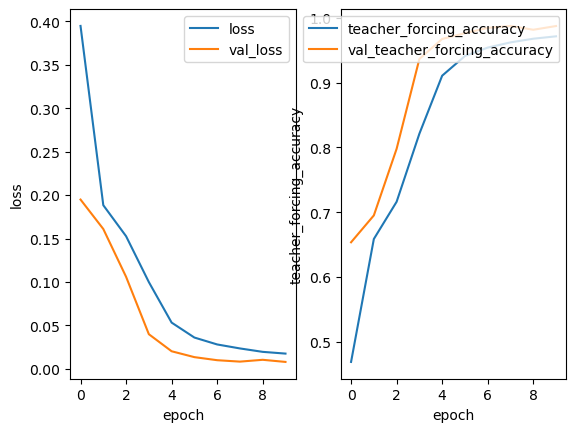

In [26]:
utils.plot_history(history, plot_attrs=('loss', 'teacher_forcing_accuracy'), val=True);

In [27]:
def evaluate_model(model, mem_ds):
    source, target, mem_source, mem_target, label = data_utils.unravel_mem_ds(mem_ds)
    target_length = np.shape(target)[1]

    pred = model_utils.mem_autoregressive_predict_batch(model, source, mem_source, mem_target, target_length,
        start_token=action_vectorizer.get_vocabulary().index('<START>'), batch_size=batch_size)

    full_seq_acc = np.all(pred == label, axis=1).mean()
    print(f'full seq acc: {full_seq_acc}')

    per_token_acc = np.mean(pred == label)
    print(f'per-token acc: {per_token_acc}')

    # teacher-forcing accuracy on test data
    _, tfacc = model.evaluate(mem_ds.batch(batch_size), verbose=False)
    print(f'teacher-forcing accuracy: {tfacc}')

    metrics = dict(pred=pred, label=label, full_seq_acc=full_seq_acc, tfacc=tfacc)

    return metrics

In [ ]:
print('TRAIN EVALUATION')
train_metrics = evaluate_model(model, mem_train_ds.take(eval_ds_size))

In [16]:
print('TEST EVALUATION')
test_metrics = evaluate_model(model, mem_test_ds.take(eval_ds_size))

TEST EVALUATION


full seq acc: 0.0
per-token acc: 0.7738163265306123
teacher-forcing accuracy: 0.8212642669677734


In [ ]:
positional_avg_acc = np.mean(train_metrics['pred'] == train_metrics['label'], axis=0)
fig, ax = plt.subplots()
ax.plot(positional_avg_acc);
ax.set_title('per-position accuracy');
ax.set_xlabel('position');
ax.set_ylabel('accuracy');

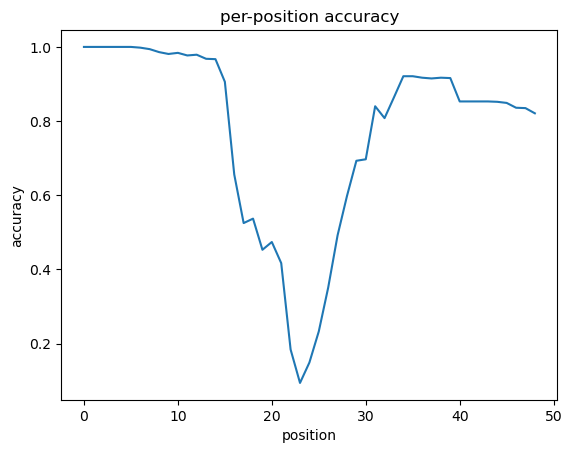

In [29]:
positional_avg_acc = np.mean(test_metrics['pred'] == test_metrics['label'], axis=0)
fig, ax = plt.subplots()
ax.plot(positional_avg_acc);
ax.set_title('per-position accuracy');
ax.set_xlabel('position');
ax.set_ylabel('accuracy');

## 2-Stage Training of Memory Model